# The Quantum Pigeonhole Paradox in Qiskit 2.x: From Strong to Weak Measurements

**Author:** Dikran Meliksetian (Qiskit Advocate)

**Summary:** This tutorial demonstrates the *three particles in two boxes* (quantum pigeonhole) paradox with Qiskit 2.x. We begin with a strong ancilla-based parity check for one pair, then show why checking all three pairs at once collapses the effect. Finally, we restore the paradox using a **weak, reversible probe** (compute → weak-poke → uncompute) that preserves the interference required by post-selection. The notebook includes confidence-interval estimates for the weak readout.

**Learning goals**
- Understand the pre-/post-selection version of the quantum pigeonhole paradox.
- Implement ancilla-based strong parity checks in Qiskit.
- See why multiple which-path marks destroy interference.
- Implement a weak measurement via compute → $R_y(\varepsilon)$ → uncompute.
- Analyze postselected results and compute confidence intervals.

**Qiskit version:** 2.x



## 1. Background
The **quantum pigeonhole paradox** is a striking illustration of how quantum correlations defy classical logic. In classical reasoning, placing three pigeons into two boxes guarantees that at least two pigeons share the same box — a simple consequence of the pigeonhole principle. 

However, in the quantum realm, if we prepare three particles in a superposition of being in both boxes and then postselect them in a specific final state, it turns out that **no two particles are ever found in the same box** within the postselected ensemble. Each pair, when examined through a suitable measurement, appears to occupy different boxes, even though only two boxes exist. This paradox arises from the nonclassical interplay of quantum superposition, entanglement, and post-selection, revealing that the notion of “being in the same place” loses its classical meaning when quantum interference and measurement context are taken into account.

Formally, we label the two boxes by computational basis states $\ket{0}\equiv\ket{L}$ and $\ket{1}\equiv\ket{R}$; and consider three qubits (particles) with $$\text{pre-selection: } \ket{\Psi}=\ket{+}^{\otimes 3},\qquad \ket{+}=\tfrac{1}{\sqrt{2}}(\ket{0}+\ket{1}),$$ and post-select each qubit in the basis $$\ket{\phi}=\tfrac{1}{\sqrt{2}}(\ket{0}+i\ket{1}), \quad \text{i.e., project onto }\ket{\Phi}=\ket{\phi}^{\otimes 3}.$$
For any pair $(i,j)$, we define the *same box* projector (acting as identity on the remaining qubit $k$): $$\Pi^{\text{same}}_{ij}=\big(\ket{00}\!\bra{00}+\ket{11}\!\bra{11}\big)_{ij}\otimes I_k.$$
In this setting, one finds $\langle \Phi|\,\Pi^{\text{same}}_{ij}\,|\Psi\rangle=0$ for each pair $(i,j)$, suggesting that within the postselected subensemble **no two particles share a box**. We will explore how measurement back-action and post-selection interplay to produce (or erase) this effect.

## 2. Verifying the Pigeonhole paradox on a Quantum Computer

The quantum pigeonhole paradox cannot be directly measured on a quantum computer because the act of measurement itself destroys the delicate quantum interference on which the paradox depends. The phenomenon arises only within a postselected subensemble of states — those that satisfy both a specific pre-selection and a specific post-selection condition. Any attempt to measure all pairwise correlations simultaneously, or to perform strong projective measurements on the “boxes,” collapses the superposition and erases the interference pattern that makes the paradox observable. To probe it experimentally, one must therefore use indirect measurements that reveal partial information about correlations without disturbing the underlying quantum coherence. This necessity makes the paradox a powerful demonstration of the difference between classical observation and quantum inference: the effect exists not as a directly observable state, but as a statistical feature of carefully prepared and postselected quantum ensembles

In the single-ancilla implementation of the quantum pigeonhole paradox, we use one extra qubit as a probe to check whether a chosen pair of data qubits (say qubits 0 and 1) are in the same or different “box.” The idea is to encode the parity of the two qubits into the ancilla without directly measuring the data qubits themselves. We start by preparing the three data qubits in the superposition state $\ket{\Psi}=\ket{+}^{\otimes 3}$, corresponding to each particle being equally likely in both boxes. Then we apply two CNOT gates—one controlled by qubit 0 and one by qubit 1—with the ancilla as the target, followed by an X gate on the ancilla to create the logical XNOR of the two data qubits. This operation flips the ancilla if exactly one of the two control qubits is $\ket{1}$, leaving it unchanged if both are the same (00 or 11). In this way, the ancilla encodes whether the pair is different (ancilla = 0) or the same (ancilla = 1). After this encoding, we “rotate” the three data qubits to the post-selection basis $\{\ket{\phi},\ket{\phi}^\dagger\}$ and measure all qubits. By keeping only the shots in which all data qubits are found in the desired post-selected state $\ket{\Phi}=\ket{+}^{\otimes 3}$, i.e, when the corresponding measurement is 000, we effectively reproduce the paradoxical prediction: the ancilla—serving as an indirect correlation meter—shows that the chosen pair is never “in the same box,” even though this is impossible classically.



## 3. Single-ancilla check (one pair)

We encode the parity of $(q_0,q_1)$ into an ancilla $a_{01}$ with two CNOTs: $a_{01} \leftarrow q_0 \oplus q_1$. Interpreting ancilla `0` as **same** (00/11) and `1` as **different** (01/10), we then rotate data to the $\ket{\phi}$ basis and measure. Within postselected shots, this often shows a strong bias toward **different** for that pair.

To perform the post-selection, we measure each data qubit in the basis of the state $\ket{\phi} = \frac{1}{\sqrt{2}} (\ket{0} + i\ket{1}$.
This is an eigenstate of the Pauli-Y operator, so this is equivalent to a Y-basis measurement.
A standard Y-basis measurement is implemented by applying a basis-change circuit before the standard Z-basis measurement.
The unitary for this transformation is the adjoint of the state preparation circuit for $\ket{\phi}$ (which is an H gate then an S gate).The required transformation is therefore $U^{\dagger} = (S H)^{\dagger} = H S^{\dagger}$.
This sequence of gates (Hadamard followed by S-dagger) maps the target state $\ket{\phi}$ to the computational state $\ket{0}$.
As a result, a successful post-selection on all three qubits in the $\ket{\phi} state corresponds to measuring the classical bits '000'.

### Setup the circuit
In this tutorial we use Qiskit2.x


In [31]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import qiskit
import qiskit_aer
import numpy as np
from math import pi, sqrt
import matplotlib.pyplot as plt  # if adding visualizations

print(f"Qiskit version: {qiskit.__version__}")
print(f"Qiskit Aer version: {qiskit_aer.__version__}")

# we are using a fixed seed to have reproducibility

backend = AerSimulator(seed_simulator=42)


Qiskit version: 2.1.1
Qiskit Aer version: 0.17.1


The circuit is build based on he description in the previous paragraph

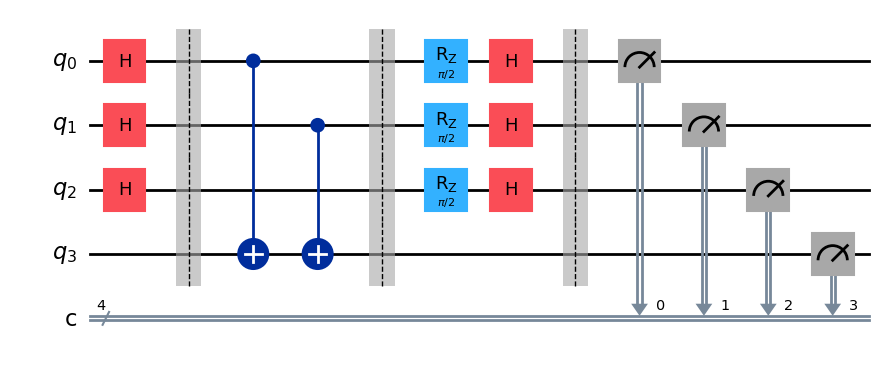

In [32]:
qc_single = QuantumCircuit(4,4)
# To perform the pre-selection, we need to prepare the qubits in |+> state, we use Hadamard gates to do this
qc_single.h([0,1,2])
qc_single.barrier()

# To perform the XNOR of qubit 0 and 1 in qubit 3, we use two CX gates
qc_single.cx(0,3); 
qc_single.cx(1,3)
qc_single.barrier()

# To perform the post-selection, we measure each data qubit in the basis of the state |φ⟩ = (1/√2)(|0⟩ + i|1⟩).
for q in [0,1,2]:
    qc_single.rz(np.pi/2, q); qc_single.h(q)
qc_single.barrier()


# We measure all the qubits
qc_single.measure([0,1,2,3],[0,1,2,3])


# Lets visualize the circuit
display(qc_single.draw("mpl"))


Postselection keeps only outcomes with data bits `c0=c1=c2=0` (i.e., $\ket{\phi}$ success on all three data qubits).

Here is a helper function to perform this postselection


In [33]:
#Note since Qiskit results are in MSB, the measured values of 
# the c0, c1, c2 are the last bits of the measured bit string 

def postselect_data_000(counts):
    kept = {}
    for b, ct in counts.items():
        if len(b) >= 3 and b[-3] == b[-2] == b[-1] == '0':
            kept[b] = ct
    return kept


We run the circuit using the simulator backend and count among the postselected data points the ones that have the ancilla=0 (same) and ancilla = 1 (different).
We then print those results

In [35]:
res = backend.run(transpile(qc_single, backend), shots=8192).result().get_counts()
kept = postselect_data_000(res)
same = sum(ct for b, ct in kept.items() if b[0]=='0')
diff = sum(ct for b, ct in kept.items() if b[0]=='1')
print({'kept': sum(kept.values()), 'same': same, 'diff': diff})
if sum(kept.values())>0:
    print('same frac:', round(same/sum(kept.values()),3), 'diff frac:', round(diff/sum(kept.values()),3))


{'kept': 1064, 'same': 0, 'diff': 1064}
same frac: 0.0 diff frac: 1.0


As expected, for all cases where the first three qubits are measured as 000, corresponding to the theoretical case of a projection on $\ket{\Phi}$, the ancillary is measured as 1, indicating that the two selected qubits are different

### Formal Justification

The preselected state with the ancilla qubit is $\ket{\Psi}\otimes\ket{0}_3$.
The operator can be symbolically written as:

$U_c = \Pi_{01}^{same}\otimes I_3 + \Pi_{01}^{diff}\otimes X_3$ 

where $\Pi_{01}^{same} = \large(\ket{0}_0\bra{0}_1 + \ket{1}_0 \bra{1}_1 \large)\otimes I_2$ and $\Pi_{01}^{diff} = I - \Pi_{01}^{same}$

This operator acting on the preselected state gives:

$U_c\large(\ket{\Psi}\otimes\ket{0}_3\large) = \Pi_{01}^{same}\ket{\Psi}\otimes \ket{0}_3 + \Pi_{01}^{diff}\ket{\Psi}\otimes \ket{1}_3$

When we measure the ancilla in $Z$ and post select the data on $\ket{\Phi}$, the probabilities of measuring the ancilla are;

$Pr(c_3 = 0, c_0c_1c_2 = 000) = \left \Vert \lang \Phi \mid \Pi_{01}^{same} \mid \Psi \rang \right \Vert^2$ and $Pr(c_3 = 1, c_0c_1c_2 = 000) = \left \Vert \lang \Phi \mid \Pi_{01}^{diff} \mid \Psi \rang \right \Vert^2$

So the conditional probability that the pair is "same" is 

$\displaystyle Pr(c_3 = 0 \mid c_0c_1c_2 = 000) = \frac{ \left \Vert \lang \Phi \mid \Pi_{01}^{same} \mid \Psi \rang \right \Vert^2 } { \left \Vert \lang \Phi \mid \Pi_{01}^{same} \mid \Psi \rang \right \Vert^2 + \left \Vert \lang \Phi \mid \Pi_{01}^{diff} \mid \Psi \rang \right \Vert^2 }$

since $\lang \Phi \mid \Pi_{01}^{same} \mid \Psi \rang = 0$ for the pigeonhole setup, then Pr(same) =0 and Pr(diff) = 1.



### Checking other pairs with a single ancilla

The paradox and the chosen pre-/post-selection are **symmetric** under permutations of the three qubits. If we couple the ancilla to $(0,2)$ or $(1,2)$ instead of $(0,1)$, we obtain **the same postselected statistics** (up to sampling noise). This symmetry is one of the signatures of the paradox: every pair *seems* to avoid sharing a box.


In [36]:
def single_pair_result(i,j,shots=8192):
    qc = QuantumCircuit(4,4)
    qc.h([0,1,2])
    qc.cx(i,3); qc.cx(j,3)
    for q in [0,1,2]:
        qc.rz(np.pi/2, q); qc.h(q)
    qc.measure([0,1,2,3],[0,1,2,3])
    res = backend.run(transpile(qc, backend), shots=shots).result().get_counts()
    kept = postselect_data_000(res)
    same = sum(ct for b, ct in kept.items() if b[0]=='0')
    diff = sum(ct for b, ct in kept.items() if b[0]=='1')
    tot = same+diff
    return {'pair':(i,j), 'kept': tot, 'same_frac': (same/tot if tot else np.nan), 'diff_frac': (diff/tot if tot else np.nan)}

for pair in [(0,1),(0,2),(1,2)]:
    print(single_pair_result(*pair))


{'pair': (0, 1), 'kept': 1064, 'same_frac': 0.0, 'diff_frac': 1.0}
{'pair': (0, 2), 'kept': 1064, 'same_frac': 0.0, 'diff_frac': 1.0}
{'pair': (1, 2), 'kept': 1064, 'same_frac': 0.0, 'diff_frac': 1.0}


The results are as expected

## 5. Three ancillas 

Instead of checking each pair with a different run, we try to encode **all three parities at once** on three separate ancillas and keep them encoded through post-selection


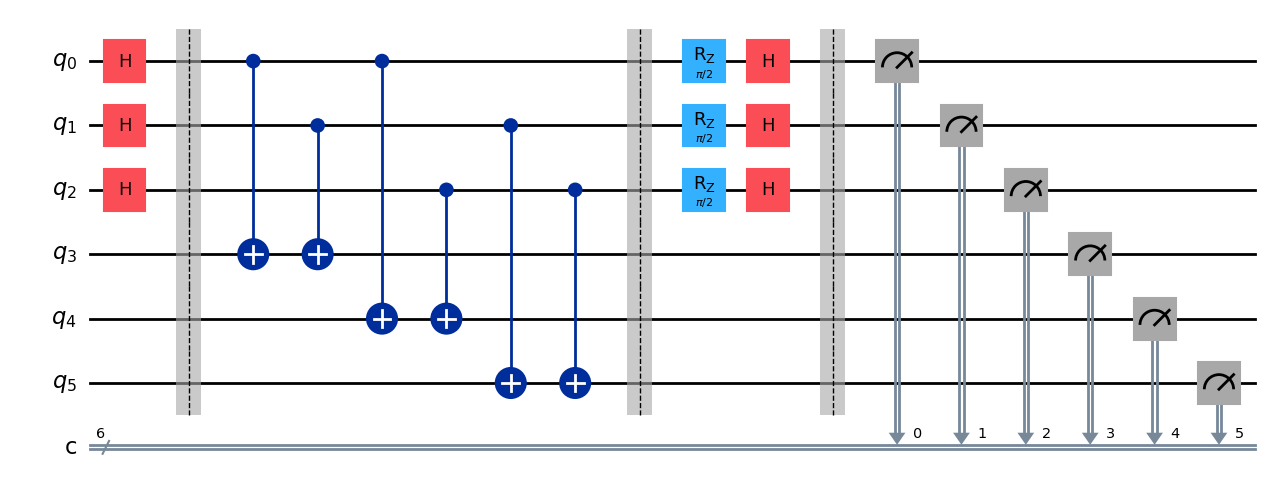

In [37]:
qc_multi = QuantumCircuit(6,6)
qc_multi.h([0,1,2])
qc_multi.barrier()
qc_multi.cx(0,3); qc_multi.cx(1,3)
qc_multi.cx(0,4); qc_multi.cx(2,4)
qc_multi.cx(1,5); qc_multi.cx(2,5)
qc_multi.barrier()
for q in [0,1,2]:
    qc_multi.rz(np.pi/2, q); qc_multi.h(q)
qc_multi.barrier()
qc_multi.measure([0,1,2,3,4,5],[0,1,2,3,4,5])
qc_multi.draw('mpl')



In [208]:
res = backend.run(transpile(qc_multi, backend), shots=8192).result().get_counts()
kept = postselect_data_000(res)

def stats(idx):
    same = sum(ct for b, ct in kept.items() if b[idx]=='0')
    diff = sum(ct for b, ct in kept.items() if b[idx]=='1')
    tot = same+diff
    return {'kept': tot, 'same_frac': (same/tot if tot else np.nan), 'diff_frac': (diff/tot if tot else np.nan)}

print('Postselected shots kept:', sum(kept.values()))
print('(0,1):', stats(2))
print('(0,2):', stats(1))
print('(1,2):', stats(0))


Postselected shots kept: 1068
(0,1): {'kept': 1068, 'same_frac': 0.4868913857677903, 'diff_frac': 0.5131086142322098}
(0,2): {'kept': 1068, 'same_frac': 0.4953183520599251, 'diff_frac': 0.5046816479400749}
(1,2): {'kept': 1068, 'same_frac': 0.47846441947565543, 'diff_frac': 0.5215355805243446}


The result is contrary to the expected outcome. 
The key challenge: any attempt to **strongly measure** whether pairs share boxes collapses the quantum state, destroying the delicate interference that creates the paradox. Strong measurements create "which-path" information that decoheres the superposition state needed for the effect. 
Empirically, postselected counts drift to $\sim$ 50/50.

### Formal Explanation

Note $\ket{\Psi}= \ket{+}^{\otimes 3} = \frac{1}{\sqrt{8}} \sum_{x_2=0}^{1}\sum_{x_1=0}^{1}\sum_{x_0=0}^{1} \ket{x_2x_1x_0}$

Let $U_c$ be the operator representing taking the XOR operation on all pairs, then:
$$ U_c: \ket{000}\ket{x_2x_1x_0} \rightarrow \ket{s_{12}s_{02}s_{01}}\ket{x_2x_1x_0} $$
where $s_{ij} = {x_i \oplus x_j}$ 

Note also that $\lang \phi \mid 0 \rang= \frac{1}{\sqrt{2}}$ and $\braket{\phi,1}= \frac{i}{\sqrt{2}}$ and consequently $\lang \Phi \mid x_2x_1x_0\rang = \frac{1}{\sqrt{8}} i ^ {wt(x_2x_1x_0)}$ where $wt()$ is the Hamming weight

Projecting the the 3 least significant qubits of $$\frac{1}{\sqrt{8}} \sum_{x_2=0}^{1}\sum_{x_1=0}^{1}\sum_{x_0=0}^{1} \ket{{x_1 \oplus x_2}}\ket{{x_0 \oplus x_2}}\ket{{x_0 \oplus x_1}}\ket{x_2x_1x_0}$$ onto $\ket{\Phi}$, we obtain
 $$\ket{A} = \frac{1}{{8}} \sum_{x_2=0}^{1}\sum_{x_1=0}^{1}\sum_{x_0=0}^{1} \ket{{x_1 \oplus x_2}}\ket{{x_0 \oplus x_2}}\ket{{x_0 \oplus x_1}} i ^ {wt(x_2x_1x_0)}$$

 It is straighforward to evaluate the 8 possibilities to reformulate this expression as
$$\ket{A} = \frac{1}{{8}} (1-i)\large(\ket{000} - \ket{110} -\ket{101} - \ket{011}\large)$$

Since all those states have the same magnitude amplitude, the ancilla probabilities are uniformly distributed over those triples and measuring any ancilla bit will result into a 0 or a 1 with probabilty 50\% 
 

## 6. Restoring the effect: weak probe 

It is obvious that performing the XOR of a pair of data qubit in an ancilla and then measuring that qubit affects the overall system. The impact is minimal when we do that for only one pair, hence we get the expected result for that case.
However when we attempt to measure all 3 pairs in the same way, the impact destroys the delicate interference of the data qubits in the system.

In order to minimize the impact, we try to use the principlee of weak prob  

The weak, reversible probe relies on three key steps that together allow us to *store* the measurement outcome as a coherent phase shift on the ancilla — without collapsing the data qubits.

##### 1️ Compute — entangle the question
We begin by **computing** the “same box” condition onto the ancilla:
$$
U_c = \Pi^{\text{same}}_{ij} \otimes I_a + \Pi^{\text{diff}}_{ij} \otimes X_a.
$$
This entangles the ancilla with the data pair: the ancilla is flipped if the two qubits are in different boxes, and left unchanged if they are the same.
At this point the ancilla *contains the answer*, but the system remains coherent because we have not measured it.

##### 2️ Poke — apply a weak, signed rotation
Next we apply a small rotation around the \(Y\)-axis:
$$
R_y(\varepsilon) = e^{-i\frac{\varepsilon}{2}Y} \approx \begin{bmatrix}
1 & -\varepsilon/2 \\
\varepsilon/2 & 1
\end{bmatrix}.
$$
Because the ancilla’s logical state depends on whether the data qubits are the same or different, the direction of this small rotation is **opposite** in those two cases:
- For “same” pairs: the ancilla tilts by $+\varepsilon/2$.
- For “different” pairs: the ancilla tilts by $-\varepsilon/2$.

This creates a *tiny, signed phase displacement* on the ancilla’s Bloch vector — a coherent “pointer deflection” that encodes the parity information.

##### 3️ Uncompute — erase the question, keep the answer
Finally, we apply the inverse of the compute operation:
$$
U_c^\dagger = \Pi^{\text{same}}_{ij} \otimes I_a + \Pi^{\text{diff}}_{ij} \otimes X_a.
$$
This step **removes the entanglement** between the ancilla and the data, restoring the system’s superposition and preserving the interference required for post-selection.  
However, the ancilla keeps its small tilt, proportional to the *weak value*
$$
\langle X_a\rangle_{\text{post}} \approx \varepsilon\,\mathrm{Re}\!\left(
\frac{\langle\Phi|\Pi^{\text{same}}_{ij}|\Psi\rangle}{\langle\Phi|\Psi\rangle}
\right).
$$
Thus, the ancilla retains a coherent, reversible record of the measurement result.

##### 4️ Readout — use Hadamard to measure the pointer
The weak rotation leaves the ancilla tilted along the **X-axis** of the Bloch sphere.
Because quantum hardware measures in the **Z basis**, we apply a Hadamard gate before measurement:
\[
H X H = Z.
\]
This rotates the ancilla’s tilt into a measurable population bias.
A slight excess of 0’s or 1’s now reflects the **sign** of the weak pointer shift:
| Pair type | Ancilla tilt | Measured bias |
|------------|---------------|----------------|
| Same (00,11) | $+\varepsilon$ | More 0’s |
| Different (01,10) | $-\varepsilon$ | More 1’s |

#####  Summary
The ancilla acts as a *phase-sensitive probe*:
- **Compute:** entangle the observable  
- **Poke:** apply a weak, signed rotation  
- **Uncompute:** erase entanglement, keep pointer shift  
- **Hadamard + measure:** read the tiny bias  

In this way, the probe “remembers” the correlation between the qubits through a reversible, analog phase displacement — not a projective measurement — preserving the interference that makes the quantum pigeonhole paradox observable.

We first try this with the single pair measurement

### Weak Probe with single pair

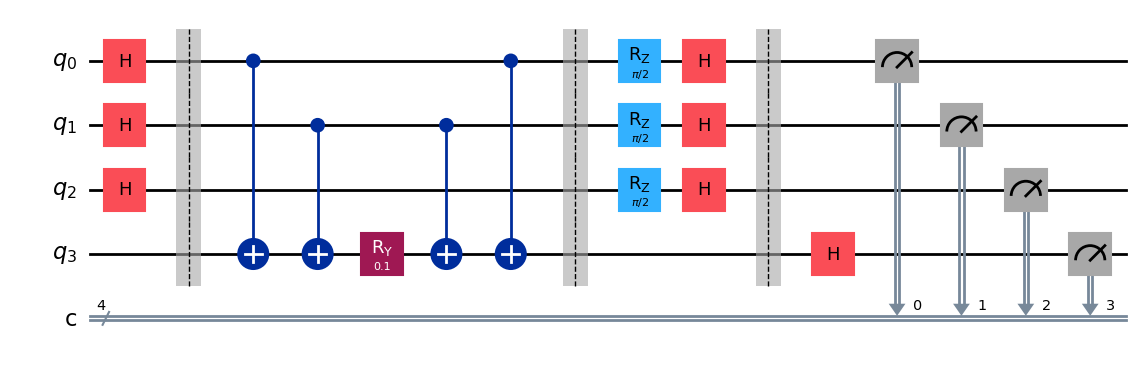

In [38]:
def compute_same(qc, a, b, t):
    qc.cx(a,t); qc.cx(b,t);

def uncompute_same(qc, a, b, t):
    qc.cx(b,t); qc.cx(a,t)

# --- Build the weak measurement circuit for given epsilon ---
def create_circuit_with_weak_prob(eps):
    qc = QuantumCircuit(4, 4)
    qc.h([0, 1, 2])                # preselection |+++>
    qc.barrier()

    # compute → poke → uncompute
    compute_same(qc, 0, 1, 3)
    qc.ry(eps, 3)
    uncompute_same(qc, 0, 1, 3)
    qc.barrier()

    # rotate data qubits for postselection
    for q in [0, 1, 2]:
        qc.rz(np.pi / 2, q)
        qc.h(q)
    qc.barrier()

    # measure ancilla in X basis
    qc.h(3)
    qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
    return qc


qc_weak = create_circuit_with_weak_prob(0.1)
qc_weak.draw('mpl')

In [40]:
eps = 0.1 # we select a small value for the perturbation 
shots = 100_000
qc_weak = create_circuit_with_weak_prob(eps)
result = backend.run(transpile(qc_weak, backend), shots=shots).result().get_counts()
kept = postselect_data_000(result)
N = sum(kept.values())
# ancilla bit is the *leftmost* bit (q3)
same = sum(ct for b, ct in kept.items() if b[0] == '0')  # ancilla=0 → "same"
diff = sum(ct for b, ct in kept.items() if b[0] == '1')  # ancilla=1 → "different"
bias = (diff - same)/N
print("Bias towards diff:", bias, " for :", N, " kept values")

Bias towards diff: 0.0995405819295559  for : 12407  kept values


In [41]:
# doing some statistical analysis, 
# we observe that our bias is more significant than the 1% threshold
print(bias, ">" ,2.576/np.sqrt(N))

0.0995405819295559 > 0.023126636142477425


### Weak Probe with three pairs

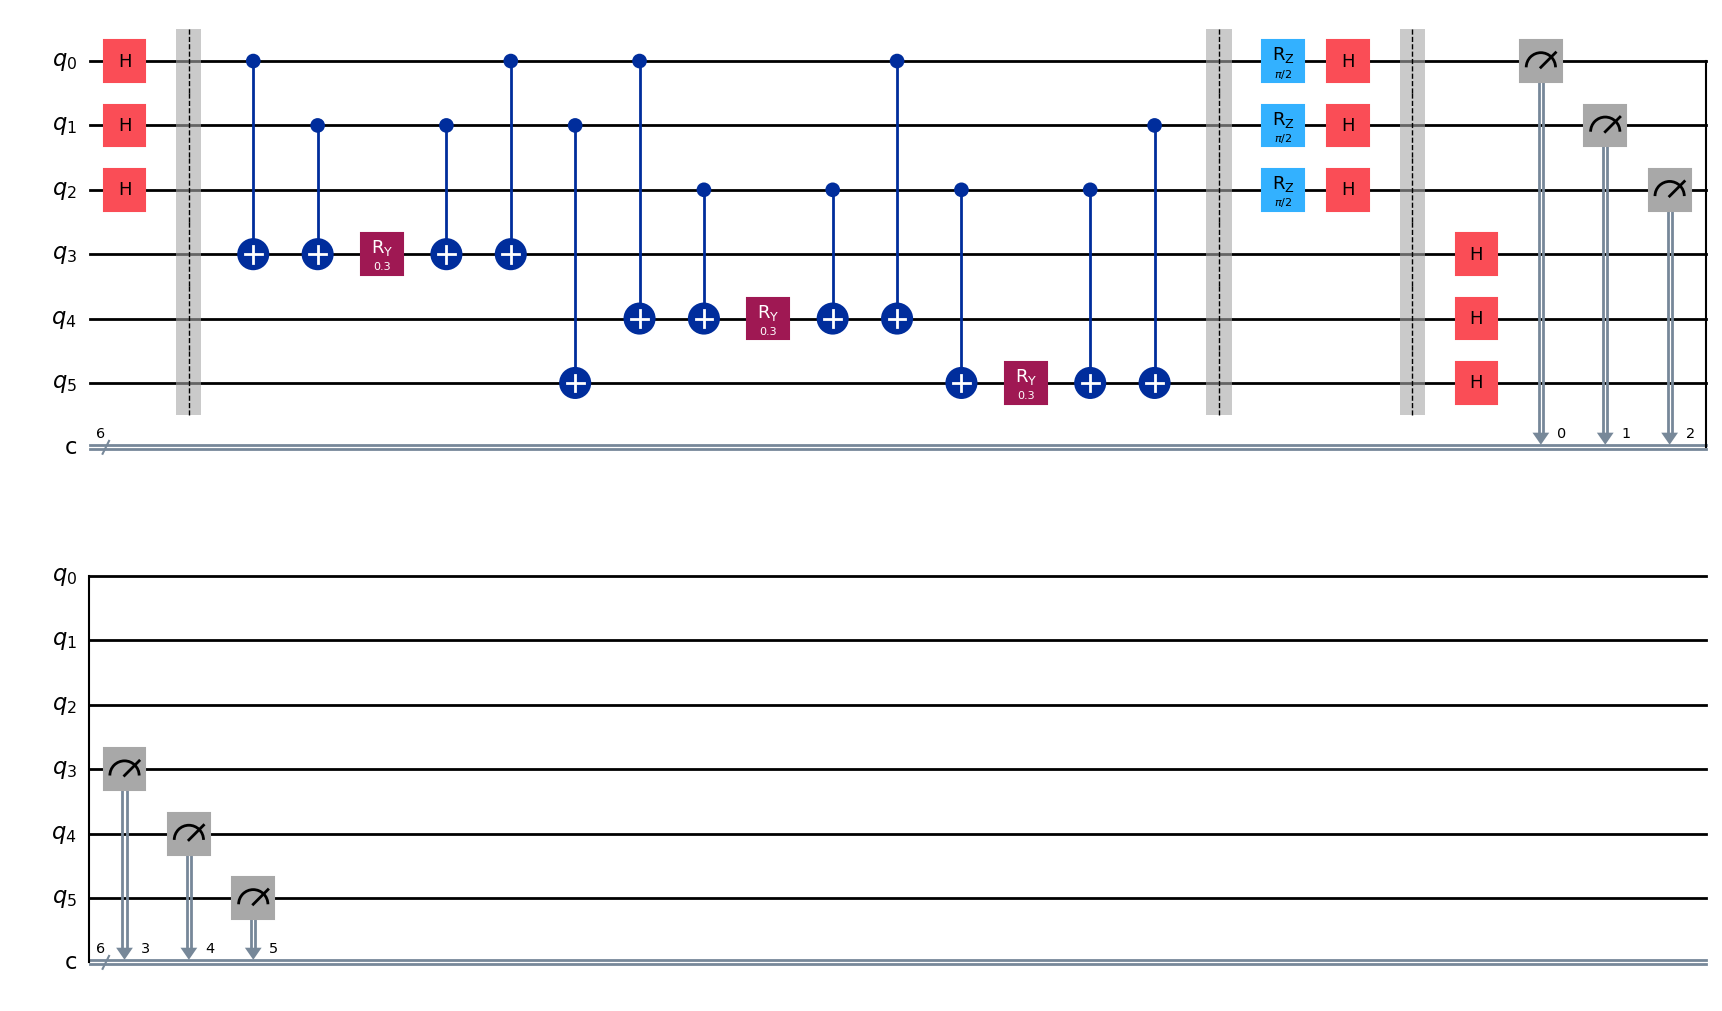

In [67]:

def create_circuit_with_weak_prob(eps):
    qc = QuantumCircuit(6,6)
    qc.h([0,1,2])
    qc.barrier()
    for (a,b,t) in [(0,1,3),(0,2,4),(1,2,5)]:
        compute_same(qc, a, b, t)
        qc.ry(eps, t)
        uncompute_same(qc, a, b, t)
    qc.barrier()
    for q in [0,1,2]:
        qc.rz(np.pi/2, q); qc.h(q)
    qc.barrier()
    qc.h([3,4,5])
    qc.measure([0,1,2,3,4,5],[0,1,2,3,4,5])
    return qc

eps = 0.3 # we select a small value for the perturbation 
qc_weak = create_circuit_with_weak_prob(eps)
display(qc_weak.draw('mpl'))


In [75]:
eps = 0.04 # we select a small value for the perturbation 
qc_weak = create_circuit_with_weak_prob(eps)
res = backend.run(transpile(qc_weak, backend), shots=100_000).result().get_counts()
kept = postselect_data_000(res)
N = sum(kept.values())
for label, idx in {(0,1):0,(0,2):1,(1,2):2}.items():
    same = sum(ct for b, ct in kept.items() if b[idx] == '0')  # ancilla=0 → "same"
    diff = sum(ct for b, ct in kept.items() if b[idx] == '1')  # ancilla=1 → "different"
    bias = (diff - same)/N
    print(label,'kept:', N, 'bias:', bias)


(0, 1) kept: 12458 bias: 0.045272114304061646
(0, 2) kept: 12458 bias: 0.039011077219457374
(1, 2) kept: 12458 bias: 0.0454326537164874


All pairs show stong significance ($5\sigma$) individually

## 7. Discussion

- A **single strong** ancilla parity test can show a strong bias after post-selection, because it only partially marks the path (some coherence remains within that parity sector).
- **Three strong** parity encodings in parallel over-mark the path: the data become fully dephased in $Z$ upon tracing ancillas, killing the interference that creates the paradox.
- The **weak, reversible probe** (compute → poke → uncompute) restores the effect by erasing which-path entanglement while leaving a tiny, readable pointer shift proportional to the **weak value**. For the pigeonhole projector $\Pi^{\text{same}}_{ij}$, this weak value is $0$ for each pair, so $\langle X\rangle\approx 0$ within postselected shots (up to noise).


## 8. References

- Y. Aharonov, D. Rohrlich, *Quantum Paradoxes: Quantum Theory for the Perplexed*, Wiley-VCH (2005), Chs. 10–11.
- N. Katz, M. Ansmann, R. C. Bialczak, E. Lucero, M. Neeley, A. O’Connell, H. Wang, M. Weides, J. M. Martinis, A. N. Korotkov, “Reversal of the weak measurement of a quantum state in a superconducting phase qubit,” *Phys. Rev. Lett.* **101**, 200401 (2008).
- Y. Aharonov, F. Colombo, S. Popescu, I. Sabadini, D. C. Struppa, J. Tollaksen, “Quantum violation of the pigeonhole principle and the nature of quantum correlations,” *PNAS* **111**(14), 4602–4605 (2014).
- Qiskit Documentation and Tutorials: <https://qiskit.org>

## Acknowledgments / Use of AI Tools
This notebook was developed with assistance from ChatGPT (model: GPT-5 Thinking, OpenAI) for drafting, code refactoring (Qiskit 2.x updates), and LaTeX/Markdown formatting. All content was reviewed and verified by the author.
